# Load libraries

In [1]:
# !pip install split-folders

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras as keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Input, Conv2D, Dense, 
                                     Flatten, Dropout, 
                                     MaxPooling2D, GlobalMaxPooling2D, 
                                     BatchNormalization)

from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, classification_report, 
                             f1_score, accuracy_score)

import random

import os
from os import listdir
from PIL import Image
import shutil
import splitfolders

# Load dataset

This is is only the csv file for the train images and their corresponding labels. The filename indicates the user url where the actual folder for the train images is located. There is also a folder for test image within the main directory shown below, but there is no test url associated with it.

In [3]:
main_dir = "C:/Users/bonni/Documents/Coding/Projects/Image_Classification/Radar_Threat"

In [4]:
train = pd.read_csv(f"{main_dir}/train_labels.csv")
print(train.shape)
train.head()

(531, 2)


,filename,label
0,C:/Users/40281299/Desktop/Datasets/LR/Knife80_...,"""3"""
1,C:/Users/40281299/Desktop/Datasets/LR/Scissor5...,"""4"""
2,C:/Users/40281299/Desktop/Datasets/LR/Gun64_LR...,"""2"""
3,C:/Users/40281299/Desktop/Datasets/LR/Knife111...,"""3"""
4,C:/Users/40281299/Desktop/Datasets/LR/Gun106_L...,"""2"""


### Personalize image url and map labels

- Convert label of string numbers to `int64`.
- Replace generic url from kaggle to user url.
- Map `int64` label to radar threat object as specified in kaggle description.
  - `{1:"Grenade", 2:"Gun", 3:"Knife", 4:"Scissor"}`

In [5]:
train["label"] = train["label"].replace('"', "", regex=True)
train["label"] = train["label"].astype("int64")

train = train.replace("C:/Users/40281299/Desktop/Datasets/LR",
                      f"{main_dir}/original_images/train", 
                      regex=True)

label2object = {1:"Grenade", 2:"Gun", 3:"Knife", 4:"Scissor"}
train["label"] = train["label"].map(label2object)
train.head()

,filename,label
0,C:/Users/bonni/Documents/Coding/Projects/Image...,Knife
1,C:/Users/bonni/Documents/Coding/Projects/Image...,Scissor
2,C:/Users/bonni/Documents/Coding/Projects/Image...,Gun
3,C:/Users/bonni/Documents/Coding/Projects/Image...,Knife
4,C:/Users/bonni/Documents/Coding/Projects/Image...,Gun


# Explore `train` label 

### `value_counts()` for `train` labels

In [6]:
label_count = train["label"].value_counts()
print(label_count)

label
Gun        174
Knife      140
Grenade    129
Scissor     88
Name: count, dtype: int64


### Visualize distribution for `train` labels

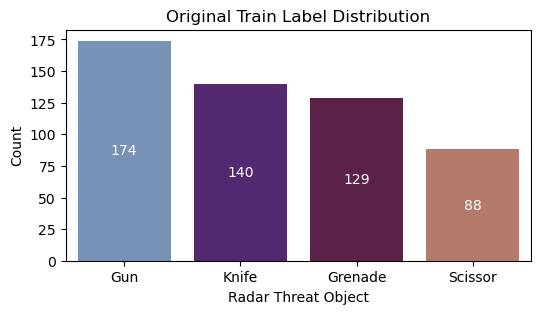

In [7]:
plt.figure(figsize=(6,3))
ax = sns.barplot(x=label_count.index, y=label_count.values, palette="twilight")

plt.title('Original Train Label Distribution')
plt.xlabel('Radar Threat Object')
plt.xticks(rotation=0)
plt.ylabel('Count')

for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height() / 2., 
            f'{int(p.get_height())}', 
            ha="center", va="center", color="white")
    
plt.show()

# Check original image count and dimensions

The function below takes in a directory or pathway that the images are located in, loads the images to open them, and finds their dimensions. It returns two lists, `images` houses all the filenames as arrays and `dimensions` houses tuples for the width and height of each image in pixels.

In [8]:
def load_images_and_get_dimensions(directory):
    images = []
    dimensions = []
    for filename in os.listdir(directory):
        if filename.endswith(".png"):
            filepath = os.path.join(directory, filename)
            image = Image.open(filepath)
            images.append(np.array(image))
            dimensions.append(image.size)
    return images, dimensions

train_path = f"{main_dir}/original_images/train"
test_path = f"{main_dir}/original_images/test"

train_images, train_dimensions = load_images_and_get_dimensions(f"{train_path}/")
test_images, test_dimensions = load_images_and_get_dimensions(f"{test_path}/")

In [9]:
print(f"Number of train images: {len(train_images)}")

# Print the shape of the first image
print(f"train_images[0].shape: {train_images[0].shape}")  

# List of dimensions confirm all train images are a uniform size of (150, 150)
# print(train_dimensions) 

Number of train images: 531
train_images[0].shape: (150, 150, 3)


In [10]:
print(f"Number of test images: {len(test_images)}")

# print the shapes for a few images
print(f"test_images[0].shape: {test_images[0].shape}")
print(f"test_images[15].shape: {test_images[15].shape}")
print(f"test_images[500].shape: {test_images[500].shape}")

# List of dimensions confirm test images are different sizes
# print(test_dimensions)  

Number of test images: 521
test_images[0].shape: (332, 359, 3)
test_images[15].shape: (150, 150, 3)
test_images[500].shape: (331, 360, 3)


There are 531 square images in the train set with a size of `150x150` pixels, while the test set has 521 images of different sizes. Some test images are `150x150` pixels, while others range from `359-360` pixels to `330-332` pixels.

# NOTE: Concerns about original structure of data

Originally, the train images were left as is and the test was split 50/50 into test and validation. It was done this way for convenience since the train and test folders are already separate. However, this split is 50-25-25 instead of 80-10-10, and the train versus test accuracies show overfitting by at least 20% no matter how simple the model architecture was or how low the values for epochs, batch size, and learning rate were set. 

Additionally, the test images contain many `150x150` images with `LR` as a part of the filename. These are the exact dimensions and filename format from the train set, which means some images might be repeated. The train set is only double the test set, and some of the train images are potentially used for both training and evaluation. The consequence is that the model is not exposed to as many new images (real test images) as much as possible, which results in extreme overfitting and underwhelming test accuracy. In other words, the model is too well-trained on the train images, and does not do well with predicting new images it is exposed to.

# Possible solution:

To fix this, any `150x150` test images with `LR` as a part of the filename is redirected to the train image folder. Since the original train and test sets have 531 and 521 images, the total is 1052 images. Consequently, there are more images to train on and the model evaluation occurs with only the new images not yet exposed to during model training.

### Transfer `LR` images from test to train set

In [11]:
train_path = f"{main_dir}/restructured_images/train"
test_path = f"{main_dir}/restructured_images/test"

test_filenames = os.listdir(test_path)
 
for test_filename in test_filenames:
    if test_filename.endswith(".png") and "LR" in test_filename:
        test_dir = os.path.join(test_path, test_filename)
        train_dir = os.path.join(train_path, test_filename)
        shutil.move(test_dir, train_dir)

### Check new image count

This looks much better in terms of train and test distribution. After splitting test into test and validation, the ratio should be approximately 80-10-10. However, visualizing the label distribution for each image set is still necessary to confirm whether a class imbalance exists, and undersampling the majority classes is one method to resolve the issues if this is the case.

In [12]:
train_images, train_dimensions = load_images_and_get_dimensions(f"{train_path}/")
test_images, test_dimensions = load_images_and_get_dimensions(f"{test_path}/")

In [13]:
print(f"Number of train images: {len(train_images)}")
print(f"Number of test images: {len(test_images)}")

Number of train images: 832
Number of test images: 220


# Separate train and test images into separate label folders

The dataset has 2 folders for train and test images, with four labels as specified below. The following function separates the compilation of images in a single `train` or `test` folder into their corresponding label folders (i.e., `Knife` images in `Knife` folder).

This allows labels to automatically be assigned to png images based on the folder they are grouped in, and will help with both visualizing class disribution and training the model in a later stage. 

**`main_dir`** = `"C:/Users/bonni/Documents/479/radar_threat"`

**`image_set`** = `restructured_images`

**`data`** = `train` or `test`

**`labels`** = `["Grenade", "Knife", "Gun", "Scissor"]`

In [14]:
def add_png_to_label_folder(image_set, data):
    image_set_folder = f"{main_dir}/{image_set}"
    data_folder = f"{main_dir}/{image_set}/{data}"
    for png_file in os.listdir(data_folder):
        for label in ["Grenade", "Knife", "Gun", "Scissor"]:
            if label in png_file:
                data_path = os.path.join(data_folder, png_file)
                label_path = os.path.join(f"{data_folder}_images/{label}", png_file)
                shutil.copy(data_path, label_path)

In [15]:
add_png_to_label_folder("restructured_images", "train")
add_png_to_label_folder("restructured_images", "test")

# Visualize new label distribution

If the new label distribution indicates a severe class imbalance, undersampling the majority class(es) is necessary to prevent biased losses and accuracies.

In [16]:
train_images_path = f"{main_dir}/restructured_images/train_images"
test_images_path = f"{main_dir}/restructured_images/test_images"

### Original image count for `train` set

In [17]:
train_grenade_images, train_grenade_dimensions = load_images_and_get_dimensions(
    f"{train_images_path}/Grenade/"
)
train_knife_images, train_knife_dimensions = load_images_and_get_dimensions(
    f"{train_images_path}/Knife/"
)
train_gun_images, train_gun_dimensions = load_images_and_get_dimensions(
    f"{train_images_path}/Gun/"
)
train_scissor_images, train_scissor_dimensions = load_images_and_get_dimensions(
    f"{train_images_path}/Scissor/"
)

### Original image count for `test` set

In [18]:
test_grenade_images, train_grenade_dimensions = load_images_and_get_dimensions(
    f"{test_images_path}/Grenade/"
)
test_knife_images, train_knife_dimensions = load_images_and_get_dimensions(
    f"{test_images_path}/Knife/"
)
test_gun_images, train_gun_dimensions = load_images_and_get_dimensions(
    f"{test_images_path}/Gun/"
)
test_scissor_images, train_scissor_dimensions = load_images_and_get_dimensions(
    f"{test_images_path}/Scissor/"
)

In [19]:
image_set_count = {
    "train":[
        len(train_grenade_images), 
        len(train_knife_images), 
        len(train_gun_images), 
        len(train_scissor_images)
    ], 
    "test":[
        len(test_grenade_images), 
        len(test_knife_images), 
        len(test_gun_images), 
        len(test_scissor_images)
    ]
}

image_set_count_df = pd.DataFrame(
    image_set_count, index = ["Grenade", "Knife", "Gun", "Scissor"]
)
image_set_count_df

,train,test
Grenade,210,50
Knife,230,50
Gun,275,50
Scissor,117,70


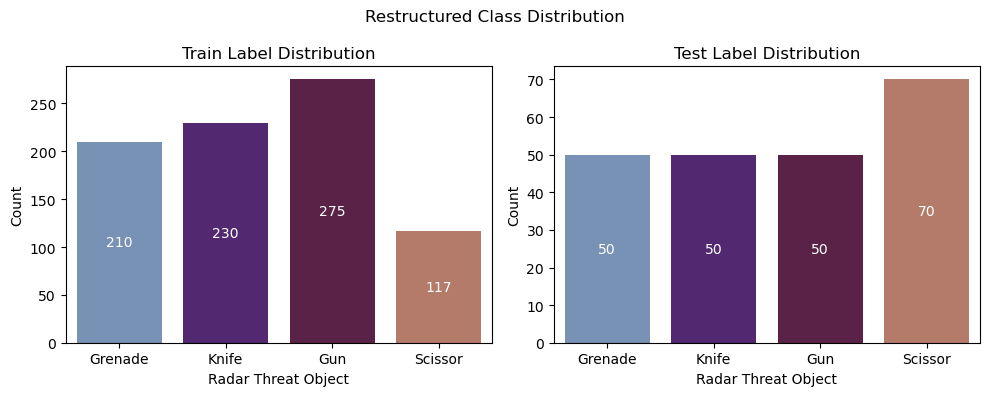

In [20]:
labels = ['Grenade', 'Knife', 'Gun', 'Scissor']

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

plt.subplot(1, 2, 1)
ax = sns.barplot(x=labels, y=image_set_count["train"], palette="twilight")

for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height() / 2., 
            f'{int(p.get_height())}', 
            ha="center", va="center", color="white")

axes[0].set_title('Train Label Distribution')
axes[0].set_xlabel('Radar Threat Object')
axes[0].set_ylabel('Count')


plt.subplot(1, 2, 2)
ax = sns.barplot(x=labels, y=image_set_count["test"], palette="twilight")

for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height() / 2., 
            f'{int(p.get_height())}', 
            ha="center", va="center", color="white")

axes[1].set_title('Test Label Distribution')
axes[1].set_xlabel('Radar Threat Object')
axes[1].set_ylabel('Count')

plt.suptitle("Restructured Class Distribution")
plt.tight_layout()
plt.show()

# Undersample majority classes

The original `Scissor` distribution only had 88 train images compared to the other three labels, which had an image count between 129 to 174. There was no undersampling in the initial model training, which led to consistently low accuracies for `Scissor` images, unsurprisingly.

Although the redirection of `LR`, or repeated `train` images in the `test` set, created a new total of 832 `train` images, the class distribution is still very imbalanced as seen above in both image sets.

To prevent biased or poor results from occurring in the restructured data, 100 images from each label in the `train` data and 25 from each in the `test` data will be undersampled. Consequently, this will create the desired 80-10-10 train-test-validation split for model training later, while still retaining the balanced class distribution.

In [21]:
def undersample_images(image_set, majority_label, num_image_samples):
    
    main_subdir = f"{main_dir}/restructured_images/{image_set}_images"
    png_images = [filename 
                  for filename in os.listdir(
                      f"{main_subdir}/{majority_label}"
                  ) 
                  if os.path.isfile(os.path.join(
                      f"{main_subdir}/{majority_label}", filename)
                                   )
                 ]
                  
    majority_sampled_images =  random.sample(png_images, num_image_samples)
    
    return majority_sampled_images


def save_sampled_images(image_set, majority_label, majority_sampled_images):    
    
    main_subdir = f"{main_dir}/restructured_images/{image_set}_images"
    
    for image in majority_sampled_images:
        label_path = os.path.join(
            f"{main_subdir}/{majority_label}", image
        )
        sample_label_path = os.path.join(
            f"{main_subdir}/sampled_images/{majority_label}", image
        )
        shutil.copy(label_path, sample_label_path)

### Undersample `train` classes and save sampled images

In [22]:
train_grenade_samples = undersample_images("train", "Grenade", 100)
train_knife_samples = undersample_images("train", "Knife", 100)
train_gun_samples = undersample_images("train", "Gun", 100)
train_scissor_samples = undersample_images("train", "Scissor", 100)

In [23]:
save_sampled_images("train", "Grenade",  train_grenade_samples)
save_sampled_images("train", "Knife",  train_knife_samples)
save_sampled_images("train", "Gun",  train_gun_samples)
save_sampled_images("train", "Scissor",  train_scissor_samples)

### Undersample `test` classes and save sampled images

In [24]:
test_grenade_samples = undersample_images("test", "Grenade", 25)
test_knife_samples = undersample_images("test", "Knife", 25)
test_gun_samples = undersample_images("test", "Gun", 25)
test_scissor_samples = undersample_images("test", "Scissor", 25)

In [25]:
save_sampled_images("test", "Grenade",  test_grenade_samples)
save_sampled_images("test", "Knife",  test_knife_samples)
save_sampled_images("test", "Gun",  test_gun_samples)
save_sampled_images("test", "Scissor",  test_scissor_samples)

# Check undersampled image count

In [26]:
train_grenade_images, train_grenade_dimensions = load_images_and_get_dimensions(
    f"{main_dir}/restructured_images/train_images/sampled_images/Grenade/"
)
train_knife_images, train_knife_dimensions = load_images_and_get_dimensions(
    f"{main_dir}/restructured_images/train_images/sampled_images/Knife/"
)
train_gun_images, train_gun_dimensions = load_images_and_get_dimensions(
    f"{main_dir}/restructured_images/train_images/sampled_images/Gun/"
)
train_scissor_images, train_gun_dimensions = load_images_and_get_dimensions(
    f"{main_dir}/restructured_images/train_images/sampled_images/Scissor/"
)

In [27]:
test_grenade_images, train_grenade_dimensions = load_images_and_get_dimensions(
    f"{main_dir}/restructured_images/test_images/sampled_images/Grenade/"
)
test_knife_images, train_knife_dimensions = load_images_and_get_dimensions(
    f"{main_dir}/restructured_images/test_images/sampled_images/Knife/"
)
test_gun_images, train_gun_dimensions = load_images_and_get_dimensions(
    f"{main_dir}/restructured_images/test_images/sampled_images/Gun/"
)
test_scissor_images, train_gun_dimensions = load_images_and_get_dimensions(
    f"{main_dir}/restructured_images/test_images/sampled_images/Scissor/"
)

In [28]:
sampled_image_set_count = {
    "sampled train":[
        len(train_grenade_images), 
        len(train_knife_images), 
        len(train_gun_images), 
        len(train_scissor_images)
    ], 
    "sampled test":[
        len(test_grenade_images), 
        len(test_knife_images), 
        len(test_gun_images), 
        len(test_scissor_images)
    ]
}

sampled_image_set_count_df = pd.DataFrame(
    sampled_image_set_count, 
    index = ["Grenade", "Knife", "Gun", "Scissor"]
)
sampled_image_set_count_df

,sampled train,sampled test
Grenade,100,25
Knife,100,25
Gun,100,25
Scissor,100,25


The train and test class distributions are now balanced.

# Double check image count for `preprocessed_images`

Note, all folders pertaining to the complete `train` and `test` sets, and their sampled images for `preprocessed_images` are manually copied from the `restructured_images` folder at this point. Restructured and preprocessed folders are kept separate to retain files for both unprocessed and preprocessed images.

To be safe, the train image count for the preprocessed data is double-checked.

In [29]:
train_images_path = f"{main_dir}/preprocessed_images/train_images"

### Train data not sampled yet

In [31]:
train_grenade_images, train_grenade_dimensions = load_images_and_get_dimensions(
    f"{train_images_path}/Grenade/"
)
train_knife_images, train_knife_dimensions = load_images_and_get_dimensions(
    f"{train_images_path}/Knife/"
)
train_gun_images, train_gun_dimensions = load_images_and_get_dimensions(
    f"{train_images_path}/Gun/"
)
train_scissor_images, train_scissor_dimensions = load_images_and_get_dimensions(
    f"{train_images_path}/Scissor/"
)

In [32]:
print(f"Number of train Grenade images: {len(train_grenade_images)}") 
print(f"Number of train Knife images: {len(train_knife_images)}") 
print(f"Number of train Gun images: {len(train_gun_images)}") 
print(f"Number of train Scissor images: {len(train_scissor_images)}") 

Number of train Grenade images: 210
Number of train Knife images: 230
Number of train Gun images: 275
Number of train Scissor images: 117


### Train data undersampled

In [33]:
train_grenade_images, train_grenade_dimensions = load_images_and_get_dimensions(
    f"{train_images_path}/sampled_images/Grenade/"
)
train_knife_images, train_knife_dimensions = load_images_and_get_dimensions(
    f"{train_images_path}/sampled_images/Knife/"
)
train_gun_images, train_gun_dimensions = load_images_and_get_dimensions(
    f"{train_images_path}/sampled_images/Gun/"
)
train_scissor_images, train_scissor_dimensions = load_images_and_get_dimensions(
    f"{train_images_path}/sampled_images/Scissor/"
)

In [34]:
print(f"Number of train Grenade images: {len(train_grenade_images)}") 
print(f"Number of train Knife images: {len(train_knife_images)}") 
print(f"Number of train Gun images: {len(train_gun_images)}") 
print(f"Number of train Scissor images: {len(train_scissor_images)}") 

Number of train Grenade images: 100
Number of train Knife images: 100
Number of train Gun images: 100
Number of train Scissor images: 100


Data for train looks right, and consequently, data for test should reflect this too.

# Split, scale, and normalize data

- Both the train and test are split in four folders for each label, while the test is further split into test and validation.
  - Note that `subset` can only be set to `training` or `validation`. Since `test` images are split half-and-half into `test` and `validation`, the "`training`" set is actually the `test` set.
- Scale to `128x128` since the images are RGB and normalize.

In [35]:
train_images_path = f"{main_dir}/preprocessed_images/train_images"
test_images_path = f"{main_dir}/preprocessed_images/test_images"

In [36]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.0) 
train_genflow = train_datagen.flow_from_directory(
    f"{train_images_path}/sampled_images/",
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

datagen_split = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.5  
)

test_genflow = datagen_split.flow_from_directory(
    f"{test_images_path}/sampled_images/",
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training' # must be either training or validation 
)

validation_genflow = datagen_split.flow_from_directory(
    f"{test_images_path}/sampled_images/",
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  
)

Found 400 images belonging to 4 classes.
Found 52 images belonging to 4 classes.
Found 48 images belonging to 4 classes.


# Display sample train images

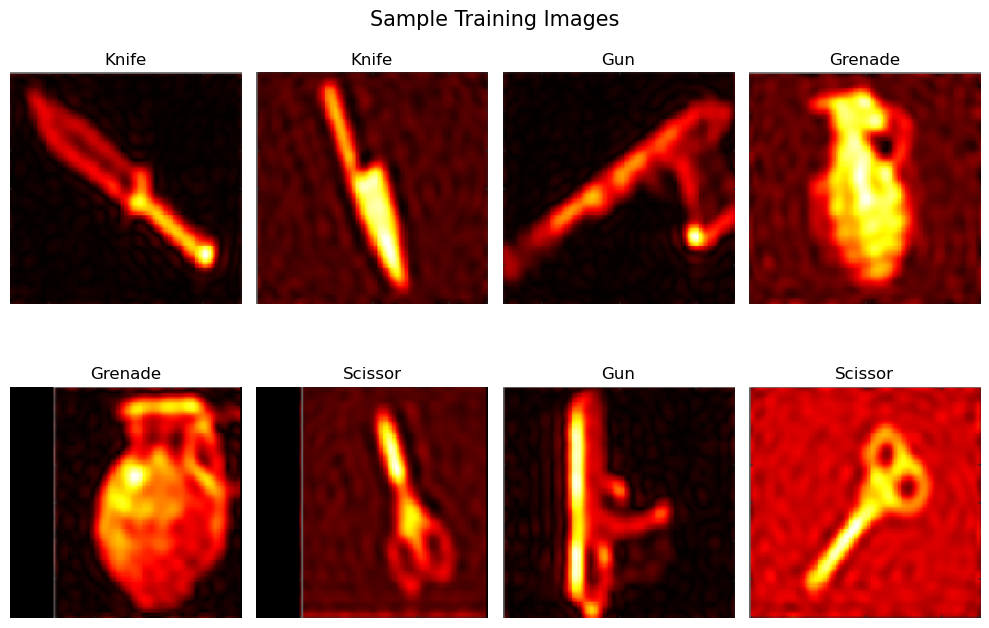

In [37]:
labels = {label: object for object, label in train_genflow.class_indices.items()}

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(10, 7))
idx = 0

for i in range(2):
    for j in range(4):
        label = labels[np.argmax(train_genflow[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_genflow[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=15)
plt.show()

# Define functions for CNN model training and evaluation
### Details on function descriptions and parameters:

(1) **`random_state`**: (This function uses tensforflow, numpy, and random seed to maintain reproducible results for the FNN.)
  - Default seed value of 100.
  
(2) **`compile_fit`**: (This function takes in tunable hyperparameters for compiling and fitting the FNN, and prints metrics.)
  - Number of epochs `epochs`
  - Batch size `batch_size`
  - Learning rate value `learning_rate`
  - Model architecture `cnn` 
  
(3) **`visualize_nn_results`**: (This function visualizes the model's losses, accuracies, and confusion matrix.)
  - Model architecture `cnn`
  - Output `cnn_fit` from the function `compile_fit`

In [38]:
def random_state(seed_value=1):
    
    tf.random.set_seed(seed_value)
    np.random.seed(seed_value)
    random.seed(seed_value)

In [39]:
def compile_fit(epochs, batch_size, learning_rate, cnn):
    
    # select Adam optimizer and learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    # compile model
    cnn.compile(optimizer = optimizer, 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])
    
    # fit model
    cnn_fit = cnn.fit(train_genflow, 
                      validation_data = validation_genflow, 
                      epochs = epochs, batch_size=batch_size, 
                      verbose=False)

    # evaluate model train accuracy
    train_loss, train_accuracy = cnn.evaluate(train_genflow)
    print(f'Training loss: {train_loss}')
    print(f'Training accuracy: {train_accuracy}')
    
    # evaluate model test accuracy
    print('\n')
    test_loss, test_accuracy = cnn.evaluate(test_genflow)
    print(f'Testing loss: {test_loss}')
    print(f'Testing accuracy: {test_accuracy}')
    
    return cnn_fit

In [40]:
def visualize_nn_results(cnn, cnn_fit):
    
    # visualize loss, accuracy, and confusion matrix
    fig, axes = plt.subplots(1,3, figsize=(10,3))


    plt.subplot(1,3,1)
    plt.plot(cnn_fit.history['loss'], label='loss', color='palevioletred')
    plt.plot(cnn_fit.history['val_loss'], label='val_loss', color='lightseagreen')
    axes[0].set_xlabel('epochs')
    axes[0].set_ylabel('loss')
    axes[0].set_title('Loss vs. Val_loss')
    plt.legend()

    plt.subplot(1,3,2)
    plt.plot(cnn_fit.history['accuracy'], label='accuracy', color='mediumorchid')
    plt.plot(cnn_fit.history['val_accuracy'], label='val_accuracy', color='orange')
    axes[1].set_xlabel('epochs')
    axes[1].set_ylabel('accuracy')
    axes[1].set_title('Accuracy vs. Val_accuracy')
    plt.legend()
    
    # confusion matrix
    plt.subplot(1,3,3)
    image_predictions = cnn.predict(test_genflow)
    y_pred = np.argmax(image_predictions, axis=1)
    y_test = test_genflow.classes
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="twilight", fmt="d", annot=True)
    plt.xlabel('Predicted Object')
    plt.ylabel('True Object')

    plt.tight_layout()
    plt.show()

    print(classification_report(y_test, y_pred, target_names=labels.values()))
    
    cnn.summary()

# Training different models

Hyperparameter tuning includes adding extra dense, pooling, or dropout layers, and adjusting `epochs`, `batch_size`, and `learning_rate`.

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.4442 - loss: 1.2366
Training loss: 1.215618371963501
Training accuracy: 0.45249998569488525


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.4511 - loss: 1.3292
Testing loss: 1.3291436433792114
Testing accuracy: 0.4423076808452606
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


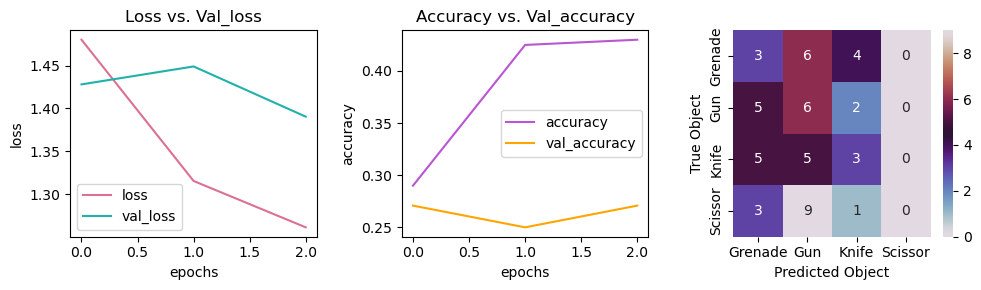

              precision    recall  f1-score   support

     Grenade       0.19      0.23      0.21        13
         Gun       0.23      0.46      0.31        13
       Knife       0.30      0.23      0.26        13
     Scissor       0.00      0.00      0.00        13

    accuracy                           0.23        52
   macro avg       0.18      0.23      0.19        52
weighted avg       0.18      0.23      0.19        52



Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_14 (Flatten)                 │ (None, 12288)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 16)                  │         196,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 4)                   │              68 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 591,710 (2.26 MB)

 Trainable params: 197,236 (770.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 394,474 (1.50 MB)

In [55]:
random_state()

cnn1 = Sequential() 
cnn1.add(MaxPooling2D(2))
cnn1.add(Flatten())
cnn1.add(Dense(16, activation='relu', input_shape=[128, 128, 3]))
cnn1.add(Dense(16, activation='relu'))
cnn1.add(Dense(16, activation='relu'))
cnn1.add(Dense(4, activation='softmax'))

cnn1_fit = compile_fit(3, 32, 0.0045, cnn1)
visualize_nn_results(cnn1, cnn1_fit)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5301 - loss: 0.9914
Training loss: 1.0073199272155762
Training accuracy: 0.5400000214576721


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.4431 - loss: 1.0908
Testing loss: 1.0787010192871094
Testing accuracy: 0.4615384638309479
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


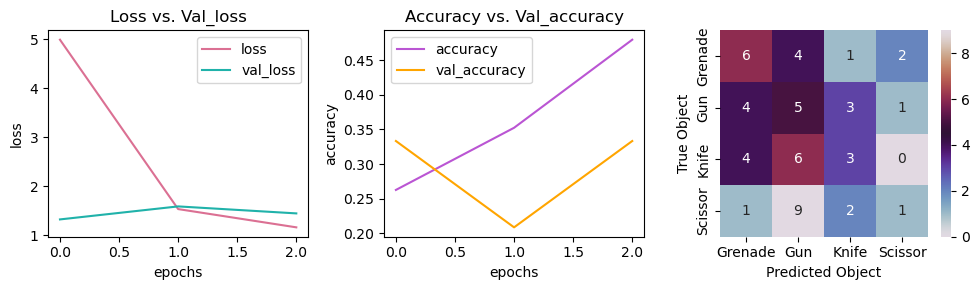

              precision    recall  f1-score   support

     Grenade       0.40      0.46      0.43        13
         Gun       0.21      0.38      0.27        13
       Knife       0.33      0.23      0.27        13
     Scissor       0.25      0.08      0.12        13

    accuracy                           0.29        52
   macro avg       0.30      0.29      0.27        52
weighted avg       0.30      0.29      0.27        52



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12288)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │         786,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,372,750 (9.05 MB)

 Trainable params: 790,916 (3.02 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,581,834 (6.03 MB)

In [42]:
random_state()

cnn2 = Sequential() 
cnn2.add(MaxPooling2D(2))
cnn2.add(Flatten())
cnn2.add(Dense(64, activation='relu', input_shape=[128, 128, 3]))
cnn2.add(Dense(64, activation='relu'))
cnn2.add(Dense(4, activation='softmax'))

cnn2_fit = compile_fit(3, 32, 0.005, cnn2)
visualize_nn_results(cnn2, cnn2_fit)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.4882 - loss: 1.1352
Training loss: 1.1805304288864136
Training accuracy: 0.4625000059604645


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5208 - loss: 1.2401
Testing loss: 1.243774175643921
Testing accuracy: 0.5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


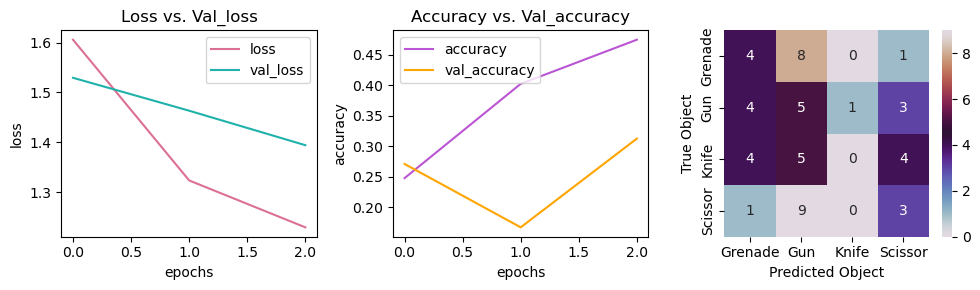

              precision    recall  f1-score   support

     Grenade       0.31      0.31      0.31        13
         Gun       0.19      0.38      0.25        13
       Knife       0.00      0.00      0.00        13
     Scissor       0.27      0.23      0.25        13

    accuracy                           0.23        52
   macro avg       0.19      0.23      0.20        52
weighted avg       0.19      0.23      0.20        52



Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_17 (Flatten)                 │ (None, 12288)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_60 (Dense)                     │ (None, 32)                  │         393,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_61 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_62 (Dense)                     │ (None, 20)                  │             340 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_63 (Dense)                     │ (None, 4)                   │              84 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,182,602 (4.51 MB)

 Trainable params: 394,200 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 788,402 (3.01 MB)

In [58]:
random_state()

cnn3 = Sequential() 
cnn3.add(MaxPooling2D(2))
cnn3.add(Flatten())
cnn3.add(Dense(32, activation='relu', input_shape=[128, 128, 3]))
cnn3.add(Dense(16, activation='relu'))
cnn3.add(Dense(20, activation='relu'))
cnn3.add(Dense(4, activation='softmax'))

cnn3_fit = compile_fit(3, 32, 0.005, cnn3)
visualize_nn_results(cnn3, cnn3_fit)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.6655 - loss: 0.8523
Training loss: 0.876936137676239
Training accuracy: 0.6349999904632568


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6314 - loss: 1.1800
Testing loss: 1.166996955871582
Testing accuracy: 0.6346153616905212
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


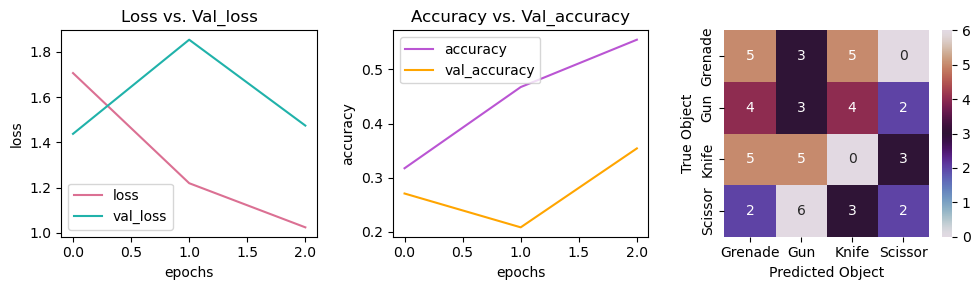

              precision    recall  f1-score   support

     Grenade       0.31      0.38      0.34        13
         Gun       0.18      0.23      0.20        13
       Knife       0.00      0.00      0.00        13
     Scissor       0.29      0.15      0.20        13

    accuracy                           0.19        52
   macro avg       0.19      0.19      0.19        52
weighted avg       0.19      0.19      0.19        52



Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_22 (Flatten)                 │ (None, 12288)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_80 (Dense)                     │ (None, 32)                  │         393,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_81 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_82 (Dense)                     │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_83 (Dense)                     │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,183,358 (4.51 MB)

 Trainable params: 394,452 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 788,906 (3.01 MB)

In [63]:
random_state()

cnn4 = Sequential() 
cnn4.add(MaxPooling2D(2))
cnn4.add(Flatten())
cnn4.add(Dense(32, activation='relu', input_shape=[128, 128, 3]))
cnn4.add(Dense(16, activation='relu'))
cnn4.add(Dense(32, activation='relu'))
cnn4.add(Dense(4, activation='softmax'))

cnn4_fit = compile_fit(3, 32, 0.004, cnn4)
visualize_nn_results(cnn4, cnn4_fit)

# Visualize predicted images based on the best model

In [64]:
image_predictions = cnn4.predict(test_genflow)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


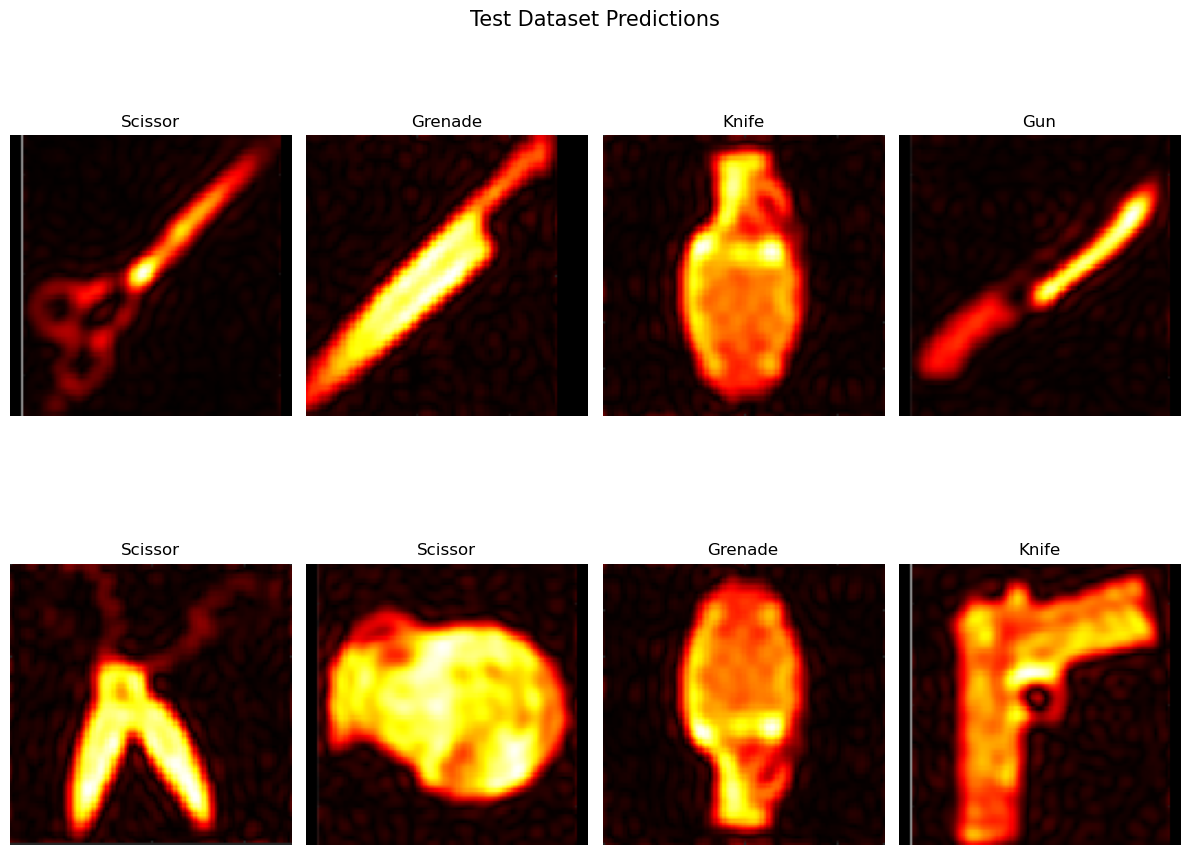

In [65]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(4):
        predicted_label = labels[np.argmax(image_predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_genflow[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=15)
plt.show()

# Misclassification analysis

`Scissor` and `Grenade` at least have some images predicted correctly, with `Scissor` seeming more accurate. While `Knife` and `Gun` seem to be incorrectly predicted for every image. If the threat object is truly a `Knife`, then it is predicted as either `Grenade` or `Gun`, and other objects (aside from `Scissor`) are usually predicted as a `Knife`, such as the `Gun`.

This could be due to the knife being straight, and the grenades don't have angles. Also, the gun looks like two straight blocks connected at an angle, and one "block" seems to be mistaken as a knife often.

# Conclusion

The model loss usually caps at 1-point something no matter the adjustments made to the `train` and `test` image count and restructuring. The `train` and `test` accuracies can both be as low as 25%, where 25% for each of the true labels is only predicted as `Grenade`, while all other values in the confusion matrix are zero at the model training's most drastic and worst scenarios. 

Adding extra pooling, dropout, or convolutional layers decreases the test accuracy significantly and also increases the gap between the train and test accuracies in some cases, which indicates severe overfitting with the higher train accuracy.

Interestingly, the `batch_size` makes no difference if the number of `epochs` and `learning_rate` remain the same within the model architecture.

Despite restructuring the image count within each folder, undersampling the class labels, and hyperparameter tuning, the gap between the train and test accuracies can range from anywhere betwen 20-30%, with the train accuracy being the higher of the two. This indicates severe overfitting.

# Best Results

The best results appear to come from the case where the `LR` images in the test set are transferred to the train set, and 400 train images and 100 images are chosen (i.e., 100 from each train class and 25 from each test class). 

Model 4 returned the highest `train` and `test` accuracy, and both are 63% or so, indicating this model does not severely overfit.

**Model 4 CNN architecture**:
- Max pooling layer with `kernel_size=2`.
- Flatten layer with no parameters.
- Three dense layers with 32, 16, and 32 neurons chronologically, and all with `activation=relu`.
  - Input layer has image shape `(128, 128, 3)`
- Output layer with 4 neurons for classes `Grenade`, `Knife`, `Gun`, and `Scissor`, and `activation=softmax`

**Hyperparameter values**:
- `epochs=3`
- `batch_size=32`
- `learning_rate=0.004`

Note: `batch_size` equal to 32, 64, etc. is ineffective if all other layers or paramters are the same.

**Train results**:
 - Loss = 0.8769
 - Accuracy = 0.6350

**Test results**:
 - Loss = 1.1670
 - Accuracy = 0.6346
 
The accuracy and loss could definitely improve with further investigation by changing the model architecture and other parameters beyond the `epochs`, `batch_size`, and `learning_rate`.